In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm

In [ ]:
# loading the dataset
train_df = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')

In [ ]:
# top 5 rows of dataset
train_df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


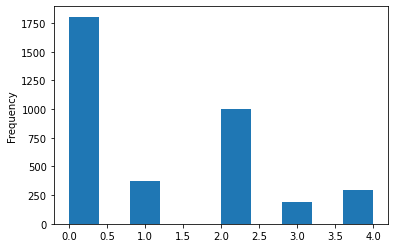

In [ ]:
# distribution of classes in dataset ( which is imbalanced )
train_df['diagnosis'].plot(kind='hist')

In [ ]:
# dimension of csv train file
train_df.shape

(3662, 2)

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

### Preprocessing the Image :

In [ ]:
def preprocess_image(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

def preprocess_image1(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

In [ ]:
N1 = train_df.shape[0]
x_train1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
for i, image_id in tqdm(enumerate((train_df['id_code']))):
    x_train1[i, :, :, :] = preprocess_image1(
        f'/content/drive/MyDrive/aptos2019-blindness-detection/train_images/{image_id}.png'
    )    

3662it [39:26,  1.55it/s]


In [ ]:
np.save('/content/drive/MyDrive/model_weights/create_dataset.npy',x_train1)

NameError: ignored

In [ ]:
x_train1=np.load('/content/drive/MyDrive/model_weights/create_dataset.npy',allow_pickle=True)

In [ ]:
#y_train = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
y_train1=np.expand_dims(train_df['diagnosis'].values,axis=1)

In [ ]:
x_train1.shape

(3662, 256, 256, 3)

In [ ]:
#y_train.sum(axis=0)

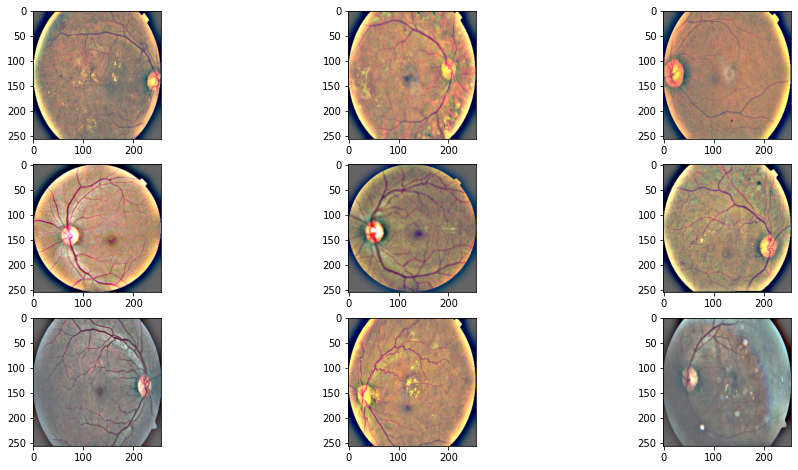

In [ ]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train1[i])

In [ ]:
del N1
gc.collect()

NameError: ignored

In [ ]:
"""y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))"""

'y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)\ny_train_multi[:, 4] = y_train[:, 4]\n\nfor i in range(3, -1, -1):\n    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])\n\nprint("Original y_train:", y_train.sum(axis=0))\nprint("Multilabel version:", y_train_multi.sum(axis=0))'

In [ ]:
#np.save('y_train1.npy',y_train_multi)
np.save('y_train1.npy',y_train1)
np.save('x_train1.npy',x_train1)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201

In [ ]:
x_train1 = np.load('x_train1.npy')
y_train1 = np.load('y_train1.npy')

In [ ]:
from sklearn.model_selection import train_test_split
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train1, y_train1, 
    random_state=42
)
print("train-validation splitted ...")

train-validation splitted ...


In [ ]:
"""del x_train1,y_train1
gc.collect()"""

'del x_train1,y_train1\ngc.collect()'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        rotation_range=20 ,      # Degree range for random rotations
        zoom_range=0.1
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain,batch_size=16,seed=20031976)
print("Image data augmentated ...")

Image data augmentated ...


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
gc.collect()

44

In [ ]:
effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)

Instructions for updating:
Colocations handled automatically by placer.


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(effnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy',f1],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
gc.collect()

60

In [ ]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch= 3362/16,
    epochs=8,
    validation_data=(x_spval, y_spval)
)    

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


210/210 [==============================] - 67s 317ms/step - batch: 105.0000 - size: 15.9716 - loss: 1.3103 - acc: 0.4911 - f1: 0.0934 - val_loss: 1.3009 - val_acc: 0.4869 - val_f1: 0.0013
Epoch 2/8
210/210 [==============================] - 68s 322ms/step - batch: 105.0000 - size: 15.9431 - loss: 1.3038 - acc: 0.4970 - f1: 0.1081 - val_loss: 1.3107 - val_acc: 0.4913 - val_f1: 0.1968
Epoch 3/8
210/210 [==============================] - 67s 321ms/step - batch: 105.0000 - size: 16.0000 - loss: 1.3090 - acc: 0.4846 - f1: 0.1005 - val_loss: 2316.1700 - val_acc: 0.4323 - val_f1: 0.0595
Epoch 4/8
210/210 [==============================] - 67s 320ms/step - batch: 105.0000 - size: 15.9431 - loss: 1.3167 - acc: 0.4890 - f1: 0.0999 - val_loss: 3.6070 - val_acc: 0.4727 - val_f1: 0.0374
Epoch 5/8
210/210 [==============================] - 68s 324ms/step - batch: 105.0000 - size: 15.9716 - loss: 1.3091 - acc: 0.4929 - f1: 0.1061 - val_loss: 1.2940 - val_acc: 0.4913 - val_f1: 0.0110
Epoch 6/8
210/210

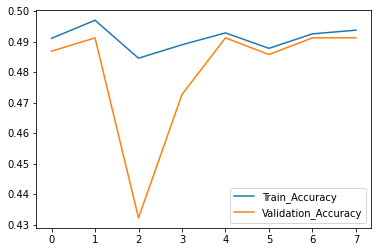

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

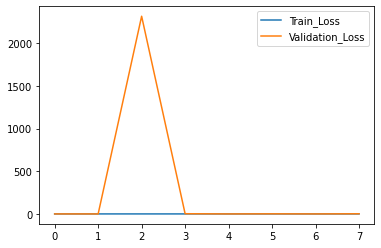

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

In [ ]:
pred = model.predict(x_spval)
pred = np.argmax(pred, axis = 1)
pred.shape

(916,)

In [ ]:
 from sklearn.metrics import confusion_matrix
 cf_matrix = confusion_matrix(pred, y_spval)
 cf_matrix

array([[450,  81, 257,  44,  84],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

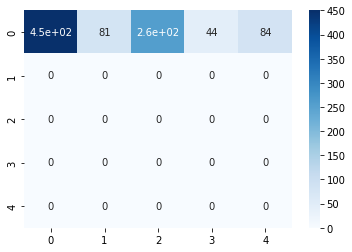

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True)

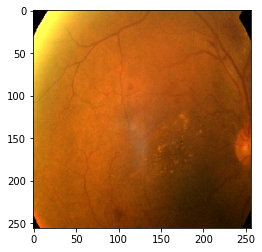

In [ ]:
img_path = "/content/drive/MyDrive/aptos2019-blindness-detection/test_images/0005cfc8afb6.png"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
#load saved model
model = load_model(‘Model.h5’) 
img_path = ‘fresh.jpg’
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds=model.predict(x)
# create a list containing the class labels
class_labels = [‘Apple’,’Banana’,’Orange’]
# find the index of the class with maximum score
pred = np.argmax(preds, axis=-1)
# print the label of the class with maximum score
print(class_labels[pred[0]])